# PlantDoc Data Processing Pipeline

This notebook transforms raw PlantDoc data into YOLO-ready format.

## Pipeline Overview
1. **Configuration**: Load paths from `.env` file
2. **Data Cleaning**: Process CSV labels and handle data quality issues
3. **Feature Engineering**: Extract species and disease information
4. **Data Transformation**: Convert to YOLO format
5. **Class Balancing**: Handle imbalanced classes
6. **Export**: Generate final dataset structure

## Step 1: Configuration Setup

Load all configuration from the `.env` file for easy parameter management.

In [17]:
import os
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Find project root (where .env file is located)
PROJECT_ROOT = Path(__file__).parent.parent if '__file__' in globals() else Path.cwd().parent

# Helper function to convert to absolute path
def make_absolute(path_str):
    """Convert relative path from .env to absolute path."""
    path = Path(path_str)
    if path.is_absolute():
        return path
    else:
        return (PROJECT_ROOT / path).resolve()

# Dataset paths (converted to absolute)
TRAIN_LABELS_CSV = make_absolute(os.getenv('TRAIN_LABELS_CSV'))
TEST_LABELS_CSV = make_absolute(os.getenv('TEST_LABELS_CSV'))
TRAIN_IMAGES_DIR = make_absolute(os.getenv('TRAIN_IMAGES_DIR'))
TEST_IMAGES_DIR = make_absolute(os.getenv('TEST_IMAGES_DIR'))

# Output disease paths (converted to absolute)
OUTPUT_DISEASE_BASE_DIR = make_absolute(os.getenv('OUTPUT_DISEASE_BASE_DIR'))
OUTPUT_DISEASE_IMAGES_TRAIN = make_absolute(os.getenv('OUTPUT_DISEASE_IMAGES_TRAIN'))
OUTPUT_DISEASE_IMAGES_VAL = make_absolute(os.getenv('OUTPUT_DISEASE_IMAGES_VAL'))
OUTPUT_DISEASE_LABELS_TRAIN = make_absolute(os.getenv('OUTPUT_DISEASE_LABELS_TRAIN'))
OUTPUT_DISEASE_LABELS_VAL = make_absolute(os.getenv('OUTPUT_DISEASE_LABELS_VAL'))

# Plant disease
PLANT_DISEASE = [d.strip() for d in os.getenv('PLANT_DISEASE').split(',')]

# Output species paths (converted to absolute)
OUTPUT_SPECIES_BASE_DIR = make_absolute(os.getenv('OUTPUT_SPECIES_BASE_DIR'))
OUTPUT_SPECIES_IMAGES_TRAIN = make_absolute(os.getenv('OUTPUT_SPECIES_IMAGES_TRAIN'))
OUTPUT_SPECIES_IMAGES_VAL = make_absolute(os.getenv('OUTPUT_SPECIES_IMAGES_VAL'))
OUTPUT_SPECIES_LABELS_TRAIN = make_absolute(os.getenv('OUTPUT_SPECIES_LABELS_TRAIN'))
OUTPUT_SPECIES_LABELS_VAL = make_absolute(os.getenv('OUTPUT_SPECIES_LABELS_VAL'))

# Plant species
PLANT_SPECIES = [s.strip() for s in os.getenv('PLANT_SPECIES').split(',')]

print("Configuration loaded successfully!")
print(f"\nProject root: {PROJECT_ROOT}")
print(f"\nTrain labels: {TRAIN_LABELS_CSV}")
print(f"Test labels: {TEST_LABELS_CSV}")
print(f"Train images: {TRAIN_IMAGES_DIR}")
print(f"\nOutput disease base: {OUTPUT_DISEASE_BASE_DIR}")
print(f"Plant disease ({len(PLANT_DISEASE)}): {', '.join(PLANT_DISEASE[:3])}...")
print(f"\nOutput species base: {OUTPUT_SPECIES_BASE_DIR}")
print(f"Plant species ({len(PLANT_SPECIES)}): {', '.join(PLANT_SPECIES[:3])}...")

Configuration loaded successfully!

Project root: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection

Train labels: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/train_labels.csv
Test labels: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/test_labels.csv
Train images: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/train

Output disease base: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease
Plant disease (16): healthy, blight, rust...

Output species base: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/species
Plant species (13): Apple, Bell Pepper, Blueberry...


## Step 2: Import Libraries

Import all necessary libraries for data processing and visualization.

In [2]:
import pandas as pd
import numpy as np
import re
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 3: Load Data

Load the training and test CSV files.

In [3]:
df_train = pd.read_csv(TRAIN_LABELS_CSV)
df_test = pd.read_csv(TEST_LABELS_CSV)

print(f"Training data: {len(df_train)} rows")
print(f"Test data: {len(df_test)} rows")
print(f"\nTraining data shape: {df_train.shape}")
print(f"\nFirst few rows:")
df_train.head()

Training data: 8469 rows
Test data: 452 rows

Training data shape: (8469, 8)

First few rows:


,filename,width,height,class,xmin,ymin,xmax,ymax
0,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,198,77,299,252
1,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,3,114,148,235
2,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,30,184,189,297
3,cherry-tree-leaves-and-fruits.jpg,350,300,Cherry leaf,226,4,346,83
4,peach-and-leaf-stock-image-2809275.jpg,1300,1099,Peach leaf,237,479,527,810


## Step 4: Data Cleaning

Clean the class names by removing "leaf" and normalizing whitespace.

In [4]:
# Clean class names: remove "leaf", normalize whitespace and underscores
df_train['class'] = (
    df_train['class']
    .str.replace(r'(?i)leaf', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.replace(r'_', ' ', regex=True)
    .str.strip()
)

df_test['class'] = (
    df_test['class']
    .str.replace(r'(?i)leaf', '', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.replace(r'_', ' ', regex=True)
    .str.strip()
)

print("Class names cleaned!")
print(f"\nSample cleaned classes:")
print(df_train['class'].value_counts().head(10))

Class names cleaned!

Sample cleaned classes:
class
Blueberry               827
Tomato yellow virus     787
Peach                   610
Raspberry               539
Strawberry              462
Tomato Septoria spot    412
Tomato                  369
Corn blight             360
Potato early blight     316
Bell pepper             312
Name: count, dtype: int64


## Step 5: Feature Engineering

Extract species and disease information from the class names.

In [5]:
def extract_species(text):
    """
    Extract the plant species from the class name.

    Args:
        text: Class name string

    Returns:
        Plant species name or None
    """
    for plant in PLANT_SPECIES:
        if re.search(rf"\b{plant}\b", text, flags=re.IGNORECASE):
            return plant
    return None

def extract_disease(text):
    """
    Extract the disease name from the class name.

    Args:
        text: Class name string

    Returns:
        Disease name or "healthy" if no disease found
    """
    for plant in PLANT_SPECIES:
        text = re.sub(rf"\b{plant}\b", "", text, flags=re.IGNORECASE).strip()
    return text if text else "healthy"

# Extract features
df_train['species'] = df_train['class'].apply(extract_species)
df_train['disease'] = df_train['class'].apply(extract_disease)

df_test['species'] = df_test['class'].apply(extract_species)
df_test['disease'] = df_test['class'].apply(extract_disease)

print("Features extracted successfully!")
print(f"\nSample of extracted features:")
print(df_train[['class', 'species', 'disease']].head(10))

Features extracted successfully!

Sample of extracted features:
    class species  disease
0  Cherry  Cherry  healthy
1  Cherry  Cherry  healthy
2  Cherry  Cherry  healthy
3  Cherry  Cherry  healthy
4   Peach   Peach  healthy
5   Peach   Peach  healthy
6   Peach   Peach  healthy
7   Peach   Peach  healthy
8   Peach   Peach  healthy
9   Peach   Peach  healthy


## Step 6: Fix Image Dimension Issues

Some images have 0 values for width/height. Fix these by reading actual image dimensions.

In [6]:
def fix_zero_dimensions(df, image_folder):
    """
    Replace 0 values in 'width' and 'height' with actual image dimensions.

    Args:
        df: DataFrame with columns ['filename', 'width', 'height']
        image_folder: Folder where images are stored

    Returns:
        Fixed DataFrame
    """
    image_folder = Path(image_folder)

    for idx, row in df.iterrows():
        if row['width'] == 0 or row['height'] == 0:
            image_path = image_folder / row['filename']
            if image_path.exists():
                with Image.open(image_path) as img:
                    w, h = img.size
                    df.at[idx, 'width'] = w
                    df.at[idx, 'height'] = h
            else:
                print(f"Warning: Image not found: {image_path}")

    return df

# Check for zero dimensions
print(f"Images with zero dimensions in train: {len(df_train[(df_train['width'] == 0) | (df_train['height'] == 0)])}")
print(f"Images with zero dimensions in test: {len(df_test[(df_test['width'] == 0) | (df_test['height'] == 0)])}")

# Fix zero dimensions
df_train = fix_zero_dimensions(df_train, TRAIN_IMAGES_DIR)
df_test = fix_zero_dimensions(df_test, TEST_IMAGES_DIR)

print("\nDimension issues fixed!")
print(f"Remaining zero dimensions in train: {len(df_train[(df_train['width'] == 0) | (df_train['height'] == 0)])}")

Images with zero dimensions in train: 4
Images with zero dimensions in test: 0

Dimension issues fixed!
Remaining zero dimensions in train: 0


## Step 7: Data Exploration - Disease Distribution

Visualize the distribution of diseases in the dataset.

Disease Distribution:
disease
healthy                     0.476916
yellow virus                0.092927
late blight                 0.052781
Septoria spot               0.048648
blight                      0.042508
early blight                0.037313
rust                        0.033652
mold                        0.032708
bacterial spot              0.031409
Powdery mildew              0.029638
spot                        0.029401
mosaic virus                0.026567
Early blight                0.023025
Scab                        0.018656
black rot                   0.014760
Gray spot                   0.008856
two spotted spider mites    0.000236
Name: proportion, dtype: float64

Total unique diseases: 17


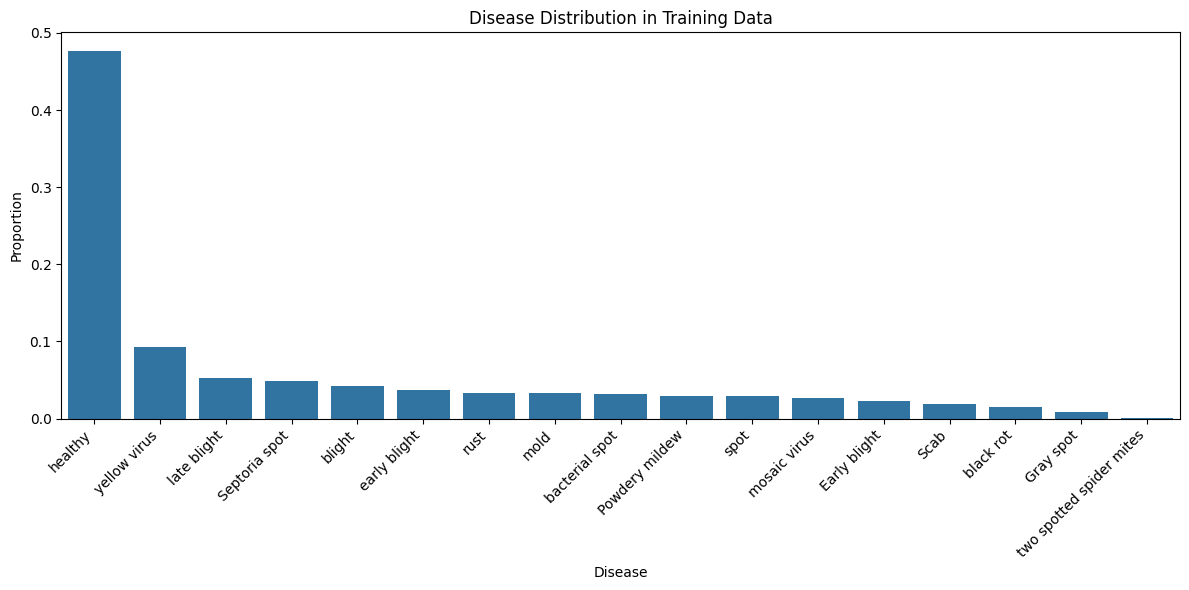

In [7]:
# Disease distribution
disease_counts = df_train['disease'].value_counts()
disease_proportions = df_train['disease'].value_counts(normalize=True)

print("Disease Distribution:")
print(disease_proportions)
print(f"\nTotal unique diseases: {len(disease_counts)}")

# Visualize
plt.figure(figsize=(12, 6))
sns.barplot(x=disease_proportions.index, y=disease_proportions.values)
plt.title('Disease Distribution in Training Data')
plt.xlabel('Disease')
plt.ylabel('Proportion')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Step 8: Remove Outliers

Remove extremely rare classes that might be noise (e.g., "two spotted spider mites").

In [8]:
# Identify very rare diseases (< 0.1% of dataset)
rare_threshold = 0.001
rare_diseases = disease_proportions[disease_proportions < rare_threshold].index.tolist()

print(f"Rare diseases (< {rare_threshold*100}%): {rare_diseases}")

# Remove rare diseases
df_disease = df_train[~df_train['disease'].isin(rare_diseases)].copy()

print(f"\nOriginal training samples: {len(df_train)}")
print(f"After removing rare diseases: {len(df_disease)}")
print(f"Removed: {len(df_train) - len(df_disease)} samples")

Rare diseases (< 0.1%): ['two spotted spider mites']

Original training samples: 8469
After removing rare diseases: 8467
Removed: 2 samples


## Step 9: Verify Image Files Exist

Check that all filenames in the CSV actually exist in the image folders.

In [9]:
def verify_image_files(df, image_folder, dataset_name="dataset"):
    """
    Verify that all files in the dataframe exist in the image folder.

    Args:
        df: DataFrame with 'filename' column
        image_folder: Path to folder containing images
        dataset_name: Name for logging purposes

    Returns:
        DataFrame with only existing files
    """
    image_folder = Path(image_folder)
    missing_files = []
    existing_mask = []

    for idx, row in df.iterrows():
        image_path = image_folder / row['filename']
        if image_path.exists():
            existing_mask.append(True)
        else:
            existing_mask.append(False)
            missing_files.append(row['filename'])

    print(f"\n{dataset_name} - File verification:")
    print(f"  Total files in CSV: {len(df)}")
    print(f"  Existing files: {sum(existing_mask)}")
    print(f"  Missing files: {len(missing_files)}")

    if missing_files:
        print(f"\n  First 10 missing files:")
        for f in missing_files[:10]:
            print(f"    - {f}")
        if len(missing_files) > 10:
            print(f"    ... and {len(missing_files) - 10} more")

    # Return dataframe with only existing files
    return df[existing_mask].copy()

# Verify training data
df_train = verify_image_files(df_train, TRAIN_IMAGES_DIR, "Training set")

# Verify test data
df_test = verify_image_files(df_test, TEST_IMAGES_DIR, "Test set")

# Update df_disease to match filtered df_train
df_disease = df_train[~df_train['disease'].isin(rare_diseases)].copy()

print(f"\n✓ Verification complete!")
print(f"  Clean training samples: {len(df_train)}")
print(f"  Clean test samples: {len(df_test)}")
print(f"  Disease-filtered training samples: {len(df_disease)}")


Training set - File verification:
  Total files in CSV: 8469
  Existing files: 8461
  Missing files: 8

  First 10 missing files:
    - NCLB.jpg
    - NCLB.jpg
    - early-blight-1.jpg
    - early-blight-1.jpg
    - early-blight-1.jpg
    - early-blight-1.jpg
    - early-blight-1.jpg
    - early-blight-1.jpg

Test set - File verification:
  Total files in CSV: 452
  Existing files: 452
  Missing files: 0

✓ Verification complete!
  Clean training samples: 8461
  Clean test samples: 452
  Disease-filtered training samples: 8459


## Step 10: YOLO Conversion Functions

Define functions to convert bounding boxes from Pascal VOC format to YOLO format, and create the class mapping.

In [10]:
def convert_bbox_to_yolo(row):
    """
    Convert bounding box from Pascal VOC format (xmin, ymin, xmax, ymax)
    to YOLO format (x_center, y_center, width, height) - all normalized.

    Args:
        row: DataFrame row with columns ['xmin', 'ymin', 'xmax', 'ymax', 'width', 'height']

    Returns:
        Tuple of (x_center, y_center, bbox_width, bbox_height) normalized to [0, 1]
    """
    x_center = (row['xmin'] + row['xmax']) / 2 / row['width']
    y_center = (row['ymin'] + row['ymax']) / 2 / row['height']
    bbox_width = (row['xmax'] - row['xmin']) / row['width']
    bbox_height = (row['ymax'] - row['ymin']) / row['height']
    return x_center, y_center, bbox_width, bbox_height

# Create disease-to-index mapping
diseases = df_disease['disease'].unique()
disease2idx = {disease: i for i, disease in enumerate(sorted(diseases))}

print("YOLO Conversion Functions ready!")
print(f"\nDisease to Index Mapping ({len(disease2idx)} classes):")
for disease, idx in disease2idx.items():
    count = len(df_disease[df_disease['disease'] == disease])
    print(f"  {idx}: {disease} ({count} samples)")

YOLO Conversion Functions ready!

Disease to Index Mapping (16 classes):
  0: Early blight (195 samples)
  1: Gray spot (75 samples)
  2: Powdery mildew (251 samples)
  3: Scab (158 samples)
  4: Septoria spot (412 samples)
  5: bacterial spot (266 samples)
  6: black rot (125 samples)
  7: blight (358 samples)
  8: early blight (310 samples)
  9: healthy (4039 samples)
  10: late blight (447 samples)
  11: mold (277 samples)
  12: mosaic virus (225 samples)
  13: rust (285 samples)
  14: spot (249 samples)
  15: yellow virus (787 samples)


## Step 11: Create Output Directories

Create the folder structure for the YOLO dataset (images and labels for train/val).

In [11]:
# Create all necessary directories
OUTPUT_DISEASE_IMAGES_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_DISEASE_IMAGES_VAL.mkdir(parents=True, exist_ok=True)
OUTPUT_DISEASE_LABELS_TRAIN.mkdir(parents=True, exist_ok=True)
OUTPUT_DISEASE_LABELS_VAL.mkdir(parents=True, exist_ok=True)

print("Output directories created successfully!")
print(f"\nDirectory structure:")
print(f"  {OUTPUT_DISEASE_BASE_DIR}/")
print(f"  ├── images/")
print(f"  │   ├── train/")
print(f"  │   └── val/")
print(f"  └── labels/")
print(f"      ├── train/")
print(f"      └── val/")

# Verify directories exist
print(f"\n✓ Train images: {OUTPUT_DISEASE_IMAGES_TRAIN}")
print(f"✓ Train labels: {OUTPUT_DISEASE_LABELS_TRAIN}")
print(f"✓ Val images: {OUTPUT_DISEASE_IMAGES_VAL}")
print(f"✓ Val labels: {OUTPUT_DISEASE_LABELS_VAL}")

Output directories created successfully!

Directory structure:
  /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease/
  ├── images/
  │   ├── train/
  │   └── val/
  └── labels/
      ├── train/
      └── val/

✓ Train images: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease/images/train
✓ Train labels: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease/labels/train
✓ Val images: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease/images/val
✓ Val labels: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease/labels/val


## Step 12: Convert and Export Dataset to YOLO Format

Convert annotations to YOLO format and copy images to the output directories.

In [12]:
def export_to_yolo(df, images_dir, output_images_dir, output_labels_dir, class_mapping):
    """
    Export dataset to YOLO format.

    Args:
        df: DataFrame with image annotations
        images_dir: Source directory containing images
        output_images_dir: Destination directory for images
        output_labels_dir: Destination directory for labels
        class_mapping: Dictionary mapping class names to indices

    Returns:
        Number of successfully exported images
    """
    exported_count = 0
    skipped_count = 0

    for filename, group in df.groupby("filename"):
        try:
            # Copy image
            src_image_path = Path(images_dir) / filename
            dst_image_path = Path(output_images_dir) / filename

            if not src_image_path.exists():
                print(f"  Skipping (not found): {filename}")
                skipped_count += 1
                continue

            shutil.copy2(src_image_path, dst_image_path)

            # Create label file
            label_file = Path(output_labels_dir) / (Path(filename).stem + ".txt")
            with open(label_file, "w") as f:
                for _, row in group.iterrows():
                    cls_idx = class_mapping[row['disease']]
                    x_center, y_center, w, h = convert_bbox_to_yolo(row)
                    f.write(f"{cls_idx} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

            exported_count += 1

        except Exception as e:
            print(f"  Error processing {filename}: {e}")
            skipped_count += 1
            continue

    return exported_count, skipped_count

# Export training data
print("Exporting training data to YOLO format...")
train_exported, train_skipped = export_to_yolo(
    df_disease,
    TRAIN_IMAGES_DIR,
    OUTPUT_DISEASE_IMAGES_TRAIN,
    OUTPUT_DISEASE_LABELS_TRAIN,
    disease2idx
)

print(f"\n✓ Training data export complete!")
print(f"  Exported: {train_exported} images")
print(f"  Skipped: {train_skipped} images")
print(f"\nTotal annotations: {len(df_disease)}")
print(f"Unique images: {df_disease['filename'].nunique()}")

Exporting training data to YOLO format...

✓ Training data export complete!
  Exported: 2343 images
  Skipped: 0 images

Total annotations: 8459
Unique images: 2343


## Step 13: Generate YAML Configuration File

Create the dataset.yaml file required by YOLO for training.


In [13]:
import yaml

# Prepare YAML content
yaml_content = {
    'path': str(OUTPUT_DISEASE_BASE_DIR.resolve()),
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(disease2idx),
    'names': {idx: disease for disease, idx in disease2idx.items()}
}

# Save YAML file
yaml_path = OUTPUT_DISEASE_BASE_DIR / 'dataset.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_content, f, default_flow_style=False, sort_keys=False)

print("✓ YAML configuration file created!")
print(f"\nLocation: {yaml_path}")
print(f"\nContent preview:")
print(f"  path: {yaml_content['path']}")
print(f"  train: {yaml_content['train']}")
print(f"  val: {yaml_content['val']}")
print(f"  nc: {yaml_content['nc']}")
print(f"\n  Classes:")
for idx in sorted(yaml_content['names'].keys()):
    print(f"    {idx}: {yaml_content['names'][idx]}")

✓ YAML configuration file created!

Location: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease/dataset.yaml

Content preview:
  path: /home/tanguy/code/Tanguyrhd/personal-projects/PlantDoc-Object-Detection/dataset/disease
  train: images/train
  val: images/val
  nc: 16

  Classes:
    0: Early blight
    1: Gray spot
    2: Powdery mildew
    3: Scab
    4: Septoria spot
    5: bacterial spot
    6: black rot
    7: blight
    8: early blight
    9: healthy
    10: late blight
    11: mold
    12: mosaic virus
    13: rust
    14: spot
    15: yellow virus


## Step 14: Dataset Summary and Statistics

Display final statistics about the processed dataset.

In [14]:
import os

def count_files_in_directory(directory):
    """Count number of files in a directory."""
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

# Count exported files
train_images_count = count_files_in_directory(OUTPUT_DISEASE_IMAGES_TRAIN)
train_labels_count = count_files_in_directory(OUTPUT_DISEASE_LABELS_TRAIN)
val_images_count = count_files_in_directory(OUTPUT_DISEASE_IMAGES_VAL)
val_labels_count = count_files_in_directory(OUTPUT_DISEASE_LABELS_VAL)

print("=" * 60)
print("DATASET PROCESSING COMPLETE")
print("=" * 60)

print(f"\n📊 DATASET STATISTICS:")
print(f"\n  Original data:")
print(f"    - Training samples: {len(df_train)}")
print(f"    - Test samples: {len(df_test)}")
print(f"    - Unique diseases: {len(diseases)}")

print(f"\n  After filtering:")
print(f"    - Cleaned training samples: {len(df_disease)}")
print(f"    - Removed rare diseases: {rare_diseases}")

print(f"\n  Exported YOLO dataset:")
print(f"    - Train images: {train_images_count}")
print(f"    - Train labels: {train_labels_count}")
print(f"    - Val images: {val_images_count}")
print(f"    - Val labels: {val_labels_count}")

print(f"\n  Class distribution:")
for disease, idx in sorted(disease2idx.items(), key=lambda x: x[1]):
    count = len(df_disease[df_disease['disease'] == disease])
    percentage = (count / len(df_disease)) * 100
    print(f"    [{idx}] {disease}: {count} samples ({percentage:.1f}%)")

print(f"\n📁 OUTPUT LOCATION:")
print(f"    {OUTPUT_DISEASE_BASE_DIR}")

print(f"\n📝 YAML CONFIG:")
print(f"    {OUTPUT_DISEASE_BASE_DIR / 'dataset.yaml'}")

print(f"\n✅ Ready for YOLO training!")
print("=" * 60)

DATASET PROCESSING COMPLETE

📊 DATASET STATISTICS:

  Original data:
    - Training samples: 8461
    - Test samples: 452
    - Unique diseases: 16

  After filtering:
    - Cleaned training samples: 8459
    - Removed rare diseases: ['two spotted spider mites']

  Exported YOLO dataset:
    - Train images: 2343
    - Train labels: 2343
    - Val images: 0
    - Val labels: 0

  Class distribution:
    [0] Early blight: 195 samples (2.3%)
    [1] Gray spot: 75 samples (0.9%)
    [2] Powdery mildew: 251 samples (3.0%)
    [3] Scab: 158 samples (1.9%)
    [4] Septoria spot: 412 samples (4.9%)
    [5] bacterial spot: 266 samples (3.1%)
    [6] black rot: 125 samples (1.5%)
    [7] blight: 358 samples (4.2%)
    [8] early blight: 310 samples (3.7%)
    [9] healthy: 4039 samples (47.7%)
    [10] late blight: 447 samples (5.3%)
    [11] mold: 277 samples (3.3%)
    [12] mosaic virus: 225 samples (2.7%)
    [13] rust: 285 samples (3.4%)
    [14] spot: 249 samples (2.9%)
    [15] yellow virus:

## Step 15: Balance Dataset - Augment Underrepresented Classes

Balance the dataset by duplicating underrepresented disease classes to reach ~1000 samples each.
Note: The "healthy" class will be handled via class weights during training.

In [15]:
# Configuration
TARGET_SAMPLES_PER_CLASS = 1000
HEALTHY_CLASS = "healthy"

# Analyze current distribution
disease_counts = df_disease['disease'].value_counts()
print("Current class distribution:")
for disease, count in disease_counts.items():
    print(f"  {disease}: {count} samples")

# Separate healthy and disease samples
df_healthy = df_disease[df_disease['disease'] == HEALTHY_CLASS].copy()
df_diseases_only = df_disease[df_disease['disease'] != HEALTHY_CLASS].copy()

print(f"\n📊 Before balancing:")
print(f"  Healthy samples: {len(df_healthy)}")
print(f"  Disease samples: {len(df_diseases_only)}")

# Balance disease classes (excluding healthy)
balanced_dfs = []

for disease, group in df_diseases_only.groupby("disease"):
    n_samples = len(group)
    n_to_add = TARGET_SAMPLES_PER_CLASS - n_samples

    if n_to_add > 0:
        print(f"\n  {disease}: {n_samples} → {TARGET_SAMPLES_PER_CLASS} (adding {n_to_add} duplicates)")

        # Keep original samples
        balanced_dfs.append(group)

        # Add duplicates
        duplicates_needed = n_to_add
        dup_counter = 0

        while duplicates_needed > 0:
            # Take samples cyclically
            n_batch = min(duplicates_needed, n_samples)
            batch = group.iloc[:n_batch].copy()

            # Modify filenames to avoid conflicts
            batch['filename'] = batch['filename'].apply(
                lambda x: f"{Path(x).stem}_dup{dup_counter}_{Path(x).suffix}"
            )
            batch['filename'] = batch['filename'].str.replace('_dup', '_dup')
            batch['filename'] = batch.apply(
                lambda row: f"{Path(row['filename']).stem.split('_dup')[0]}_dup{dup_counter + row.name % n_samples}{Path(row['filename']).suffix}",
                axis=1
            )

            balanced_dfs.append(batch)
            duplicates_needed -= n_batch
            dup_counter += 1
    else:
        print(f"\n  {disease}: {n_samples} (already >= target)")
        balanced_dfs.append(group)

# Combine balanced diseases with healthy samples
df_balanced = pd.concat(balanced_dfs + [df_healthy], ignore_index=True)

print(f"\n📊 After balancing:")
print(f"  Total samples: {len(df_balanced)}")
print(f"\nFinal class distribution:")
final_counts = df_balanced['disease'].value_counts()
for disease in sorted(final_counts.index):
    count = final_counts[disease]
    print(f"  {disease}: {count} samples")

# Update disease2idx mapping if needed
diseases_balanced = df_balanced['disease'].unique()
disease2idx = {disease: i for i, disease in enumerate(sorted(diseases_balanced))}

print(f"\n✓ Dataset balanced!")
print(f"\n  Note: 'healthy' class is over-represented ({final_counts[HEALTHY_CLASS]} samples)")
print(f"   Recommendation: Use class weights during YOLO training to handle this imbalance.")

Current class distribution:
  healthy: 4039 samples
  yellow virus: 787 samples
  late blight: 447 samples
  Septoria spot: 412 samples
  blight: 358 samples
  early blight: 310 samples
  rust: 285 samples
  mold: 277 samples
  bacterial spot: 266 samples
  Powdery mildew: 251 samples
  spot: 249 samples
  mosaic virus: 225 samples
  Early blight: 195 samples
  Scab: 158 samples
  black rot: 125 samples
  Gray spot: 75 samples

📊 Before balancing:
  Healthy samples: 4039
  Disease samples: 4420

  Early blight: 195 → 1000 (adding 805 duplicates)

  Gray spot: 75 → 1000 (adding 925 duplicates)

  Powdery mildew: 251 → 1000 (adding 749 duplicates)

  Scab: 158 → 1000 (adding 842 duplicates)

  Septoria spot: 412 → 1000 (adding 588 duplicates)

  bacterial spot: 266 → 1000 (adding 734 duplicates)

  black rot: 125 → 1000 (adding 875 duplicates)

  blight: 358 → 1000 (adding 642 duplicates)

  early blight: 310 → 1000 (adding 690 duplicates)

  late blight: 447 → 1000 (adding 553 duplicate

## Step 16: Calculate Class Weights for Training

Calculate recommended class weights to handle the 'healthy' class imbalance during training.

In [16]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
classes = df_balanced['disease'].unique()
weights = compute_class_weight(
    'balanced',
    classes=np.array(sorted(classes)),
    y=df_balanced['disease']
)

class_weights = {disease: weight for disease, weight in zip(sorted(classes), weights)}

print("Recommended class weights for YOLO training:")
print("\nAdd these to your YOLO training configuration:\n")
print("class_weights = {")
for disease, idx in sorted(disease2idx.items(), key=lambda x: x[1]):
    weight = class_weights[disease]
    count = len(df_balanced[df_balanced['disease'] == disease])
    print(f"    {idx}: {weight:.4f},  # {disease} ({count} samples)")
print("}")

print(f"\n💡 How to use in YOLO:")
print(f"   In your training script, pass these weights to balance the loss function.")
print(f"   This will penalize the model more for mistakes on rare classes (like diseases)")
print(f"   and less for mistakes on common classes (like healthy).")

Recommended class weights for YOLO training:

Add these to your YOLO training configuration:

class_weights = {
    0: 1.1899,  # Early blight (1000 samples)
    1: 1.1899,  # Gray spot (1000 samples)
    2: 1.1899,  # Powdery mildew (1000 samples)
    3: 1.1899,  # Scab (1000 samples)
    4: 1.1899,  # Septoria spot (1000 samples)
    5: 1.1899,  # bacterial spot (1000 samples)
    6: 1.1899,  # black rot (1000 samples)
    7: 1.1899,  # blight (1000 samples)
    8: 1.1899,  # early blight (1000 samples)
    9: 0.2946,  # healthy (4039 samples)
    10: 1.1899,  # late blight (1000 samples)
    11: 1.1899,  # mold (1000 samples)
    12: 1.1899,  # mosaic virus (1000 samples)
    13: 1.1899,  # rust (1000 samples)
    14: 1.1899,  # spot (1000 samples)
    15: 1.1899,  # yellow virus (1000 samples)
}

💡 How to use in YOLO:
   In your training script, pass these weights to balance the loss function.
   This will penalize the model more for mistakes on rare classes (like diseases)
   and 